In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
plt.style.use("default")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

DATA_PATH = "datasets/summit_dbe_processed_with_time.parquet"
df = pd.read_parquet(DATA_PATH)

print(df.shape)
df.head()

(50259, 142)


,timestamp,hostname,GPU,serial,is_failure,hours_in_job,gpu_energy,gpu_usage,flag_gpumps,flag_gpudefault,flag_smt1,flag_smt2,flag_smt4,flag_nvme,flag_cpublink,flag_disableautonuma,flag_isolategpfs,flag_maximizegpfs,n_jobs_1h,jobhours_1h,n_jobs_6h,jobhours_6h,n_jobs_24h,jobhours_24h,n_jobs_120h,jobhours_120h,job_max_power,job_range_power,job_min_power,n_no_tele_6h,n_no_tele_1h,n_no_tele_15min,n_no_tele_5min,n_no_tele_1min,n_NA_power_6h,n_NA_core_temp_6h,n_NA_mem_temp_6h,n_NA_power_1h,n_NA_core_temp_1h,n_NA_mem_temp_1h,n_NA_power_15min,n_NA_core_temp_15min,n_NA_mem_temp_15min,n_NA_power_5min,n_NA_core_temp_5min,n_NA_mem_temp_5min,n_NA_power_1min,n_NA_core_temp_1min,n_NA_mem_temp_1min,power_fluct_6h,core_temp_fluct_6h,mem_temp_fluct_6h,power_fluct_1h,core_temp_fluct_1h,mem_temp_fluct_1h,power_fluct_15min,core_temp_fluct_15min,mem_temp_fluct_15min,power_fluct_5min,core_temp_fluct_5min,mem_temp_fluct_5min,power_fluct_1min,core_temp_fluct_1min,mem_temp_fluct_1min,power_fluct_lifetime,core_temp_fluct_lifetime,mem_temp_fluct_lifetime,power_avg_lifetime,core_temp_avg_lifetime,mem_temp_avg_lifetime,power_min_lifetime,power_max_lifetime,power_range_lifetime,core_temp_min_lifetime,core_temp_max_lifetime,core_temp_range_lifetime,mem_temp_min_lifetime,mem_temp_max_lifetime,mem_temp_range_lifetime,n_zero_power,n_zero_core_temp,n_zero_mem_temp,power_mean_6h,power_min_6h,power_max_6h,power_range_6h,core_temp_mean_6h,core_temp_min_6h,core_temp_max_6h,core_temp_range_6h,mem_temp_mean_6h,mem_temp_min_6h,mem_temp_max_6h,mem_temp_range_6h,power_mean_1h,power_min_1h,power_max_1h,power_range_1h,core_temp_mean_1h,core_temp_min_1h,core_temp_max_1h,core_temp_range_1h,mem_temp_mean_1h,mem_temp_min_1h,mem_temp_max_1h,mem_temp_range_1h,power_mean_15min,power_min_15min,power_max_15min,power_range_15min,core_temp_mean_15min,core_temp_min_15min,core_temp_max_15min,core_temp_range_15min,mem_temp_mean_15min,mem_temp_min_15min,mem_temp_max_15min,mem_temp_range_15min,power_mean_5min,power_min_5min,power_max_5min,power_range_5min,core_temp_mean_5min,core_temp_min_5min,core_temp_max_5min,core_temp_range_5min,mem_temp_mean_5min,mem_temp_min_5min,mem_temp_max_5min,mem_temp_range_5min,power_mean_1min,power_min_1min,power_max_1min,power_range_1min,core_temp_mean_1min,core_temp_min_1min,core_temp_max_1min,core_temp_range_1min,mem_temp_mean_1min,mem_temp_min_1min,mem_temp_max_1min,mem_temp_range_1min
0,2020-10-05 15:22:36+00:00,a06n13,3.0,3.238171e+11,0.0,0.990875,4200815.0,0.000000e+00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.995367,5.0,5.973337,7.0,23.955706,56.0,119.066958,35.0,2.0,33.0,2023.0,340.0,88.0,28.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000512,0.058937,0.125505,0.239123,0.006509,0.011990,0.226833,0.000000,0.000000,0.185185,0.000000,0.000000,0.117647,0.000000,0.000000,17.620121,0.180033,0.319890,77.229276,32.989384,30.052375,10.0,419.0,409.0,24.0,53.0,29.0,21.0,56.0,35.0,0.0,0.0,0.0,47.320172,33.0,367.0,334.0,29.894468,28.0,37.0,9.0,26.618277,25.0,36.0,11.0,33.200920,33.0,48.0,15.0,29.955521,29.0,31.0,2.0,26.936810,25.0,28.0,3.0,33.181034,33.0,35.0,2.0,30.000000,30.0,30.0,0.0,27.000000,27.0,27.0,0.0,33.147059,33.0,34.0,1.0,30.000000,30.0,30.0,0.0,27.000000,27.0,27.0,0.0,33.071429,33.0,34.0,1.0,30.000000,30.0,30.0,0.0,27.000000,27.0,27.0,0.0
1,2020-10-05 06:41:43+00:00,a07n13,3.0,3.239171e+11,0.0,3.322851,8288790.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,2.0,5.991718,5.0,23.964134,44.0,119.207576,79.0,45.0,34.0,1929.0,314.0,76.0,30.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.371020,0.008454,0.035901,0.382442,0.000000,0.013118,0.378849,0.000000,0.016064,0.334728,0.000000,0.025105,0.448980,0.000000,0.000000,17.017490,0.178113,0.334037,76.466161,32.949965,30.344240,11.0,404.0,393.0,24.0,53.0,29.0,21.0,53.0,32.0,0.0,0.0,0.0,47.499466,33.0,79.0,46.0,29.995831,29.0,31.0,2.0,26.918713,26.0,28.0,2.0,47.572733,47.0,49.0,2.0,30.000000,30.0,30.0,0.0,26.991175,26.0,27.0,1.0,47.575243,47.0,49

In [11]:
#basic failure overview
print("Total rows:", len(df))
print(df["is_failure"].value_counts())
print(df["is_failure"].value_counts(normalize=True))

Total rows: 50259
is_failure
0.0    49964
1.0      295
Name: count, dtype: int64
is_failure
0.0    0.99413
1.0    0.00587
Name: proportion, dtype: float64


In [12]:
#split failure vs normal
fail_df = df[df["is_failure"] == 1.0]
normal_df = df[df["is_failure"] == 0.0]

print("\nFailure rows shape:", fail_df.shape)
print("Normal rows shape:", normal_df.shape)


Failure rows shape: (295, 142)
Normal rows shape: (49964, 142)


In [13]:
#how failures spread over devices
print("\nTop devices with failures:")
print(fail_df.groupby(["hostname", "GPU"]).size().sort_values(ascending=False).head(10))


Top devices with failures:
hostname  GPU
f24n16    0.0    31
d37n11    5.0    24
g20n07    0.0    14
e12n03    4.0    12
d11n06    4.0    12
h50n06    2.0    12
c31n10    4.0     9
g05n01    4.0     8
e37n02    1.0     7
h28n16    1.0     7
dtype: int64


In [14]:
#compare key telemetry features at failure vs normal

key_cols = [
"power_mean_1min",
"core_temp_mean_1min",
"mem_temp_mean_1min",
"power_fluct_1h",
"core_temp_fluct_1h",
"mem_temp_fluct_1h"
]

print("Key telemetry summary for failure rows:\n")
print(fail_df[key_cols].describe())

print("\nKey telemetry summary for normal rows:\n")
print(normal_df[key_cols].describe())

Key telemetry summary for failure rows:

       power_mean_1min  core_temp_mean_1min  mem_temp_mean_1min  power_fluct_1h  core_temp_fluct_1h  mem_temp_fluct_1h
count       295.000000           295.000000          295.000000      295.000000          295.000000         295.000000
mean         67.790378            33.711309           32.265367       11.633562            0.146746           0.236743
std          60.087671             5.455128            6.002184       19.365673            0.217229           0.226940
min           6.000000            24.000000           24.958333        0.000000            0.000000           0.000000
25%          34.507744            31.845455           30.000000        0.167762            0.090702           0.170989
50%          47.883333            32.000000           30.000000        1.970412            0.090702           0.180186
75%          77.655771            34.538661           32.799153       15.882761            0.138040           0.242028
max    

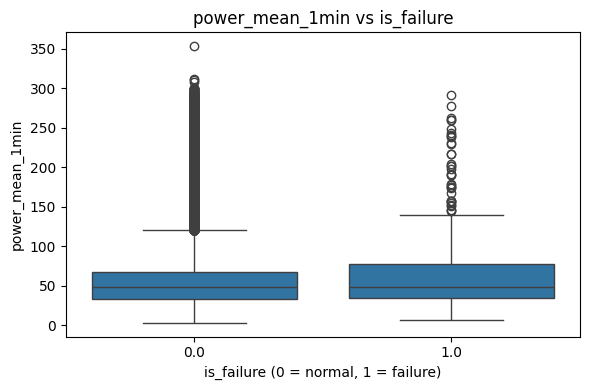

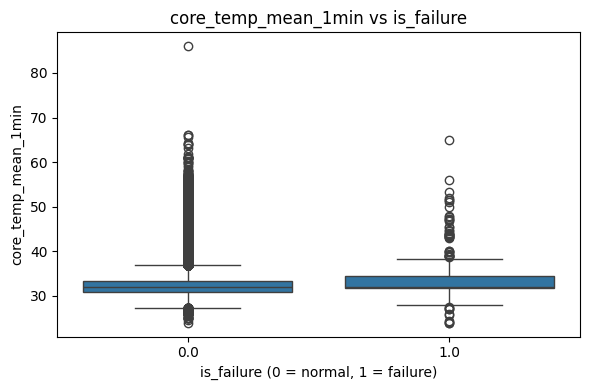

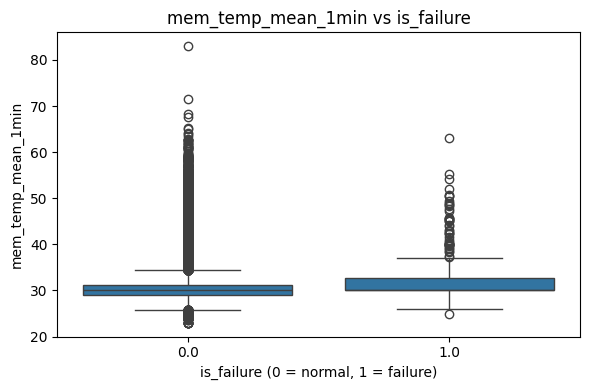

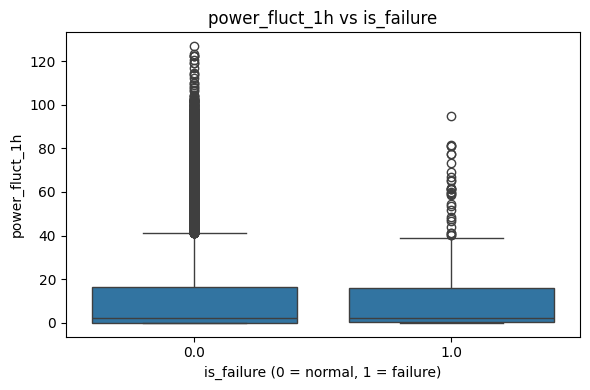

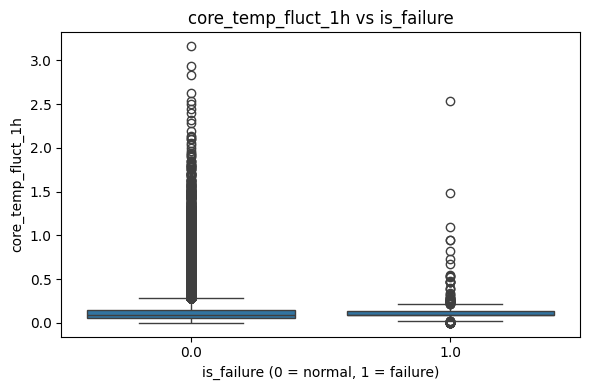

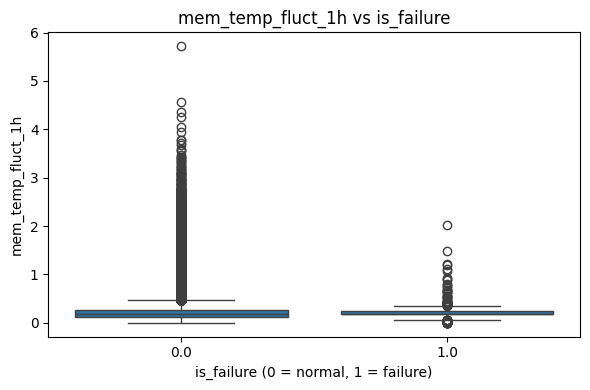

In [16]:
#quick visual comparison
for col in key_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x="is_failure", y=col)
    plt.title(f"{col} vs is_failure")
    plt.xlabel("is_failure (0 = normal, 1 = failure)")
    plt.tight_layout()
    plt.show()